## Using `sklearn`'s Classifiers

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import ast

METADATA_DIR = "data/fma_metadata/"

tracks = pd.read_csv(f"{METADATA_DIR}tracks.csv", index_col=0, header=[0, 1])
features = pd.read_csv(f"{METADATA_DIR}features.csv", index_col=0, header=[0, 1, 2])
genres = pd.read_csv(f"{METADATA_DIR}genres.csv", index_col=0)

smalL_track_ids = ast.literal_eval(open("data/fma_small_track_ids.txt").read())
tracks_features = pd.merge(tracks["track"]["genre_top"], features, left_index=True, right_index=True).loc[smalL_track_ids]

del tracks, features, smalL_track_ids

/home/yijerloh/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 3 on the right)
  warnings.warn(msg, UserWarning)


### Preprocessing
* Scale the features such that they have a mean of 0 and variance of 1
* Encode the output

In [2]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize

genre_title_to_id = dict(zip(genres.title, genres.index))
genre_ids = [genre_title_to_id[title] for title in tracks_features["genre_top"].tolist()]
tracks_features = tracks_features.drop(columns=["genre_top"])

scaler = StandardScaler().fit(tracks_features)
scaled_tracks_features = scaler.transform(tracks_features)

enc = LabelEncoder()
encoded_genre_ids = enc.fit_transform(genre_ids)

X_train, X_test, y_train, y_test = train_test_split(scaled_tracks_features, encoded_genre_ids)
y_test_binarize = label_binarize(y_test, classes=range(len(enc.classes_)))

### Visualising the raw data
* Below is t-SNE plot obtained by embedding the >500 features into 2 dimensions.
* The genres are generally quite dispersed and do not form clusters of a single genre.
* There are some general trends, for example Folk (purple) can be seen to tend to the right of the plot, or Rock (green) tends to the lower half of the plot. However, these trends are not exactly that obvious.

In [5]:
from sklearn.manifold import TSNE

embedded_tracks_features = TSNE(n_components=2).fit_transform(tracks_features)

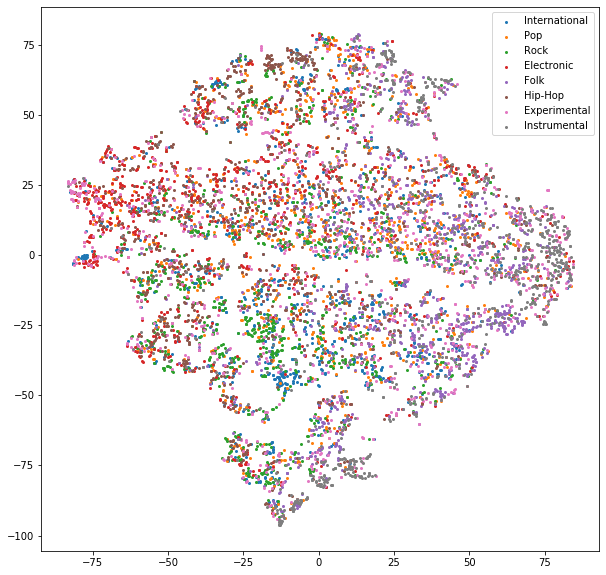

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))

for genre_id in enc.classes_:
    genre_indices = [i for i, id in enumerate(genre_ids) if id == genre_id]
    axs.scatter(embedded_tracks_features[genre_indices, 0], embedded_tracks_features[genre_indices, 1], label=genres.loc[genre_id]["title"], s=4)

axs.legend()

### Classifying Genre 
* Classifiers then can be used:
    * linear_model - LogisticRegression, RidgeClassifierCV
    * svm - LinearSVC, SVC
    * ensemble - RandomForestClassifier, AdaBoostClassfier, GradientBoostingClassifier
    * naive_bayes - GaussianNB
    * discriminant_analysis - LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
    * multiclass - OneVsRestClassifier
    * neighbors - KNeighborsClassifier
    * neural_network - MLPClassifier
* Attempted to use `GridSearchCV` to search for better parameters for the classifiers. However, found that the accuracy remained in regions +-0.03 of its original value.
* The scores and ROC curves below show that SVM, LDA and MLP classifiers work well here
* Note that the accuracy score here is a valid metric to determine the success of the classifier, since the distribution across all genres are balanced. Note that the score of >0.5 already shows that there are features that does correlate with genre, given that a null hypothesis would give a score of 0.125 (1/8) since there are 8 genres.
* Obtaining the feature importances of the RandomForestClassifier shows relatively equal importances across all features


In [3]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from tqdm import tqdm
import time

classifiers = {
    "LR": LogisticRegression(), "RC": RidgeClassifier(),
    "LSVM": LinearSVC(),
    "SVM": SVC(),
    "RFC": RandomForestClassifier(), "ABC": AdaBoostClassifier(),
    "GNB": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(), "QDA": QuadraticDiscriminantAnalysis(),
    "OvRC": OneVsRestClassifier(LogisticRegression()),
    "KNC": KNeighborsClassifier(),
    "MLP": MLPClassifier()
}

score = dict()
fpr = dict()
tpr = dict()

for name, clf in classifiers.items():
    start = time.time()
    print(f"\n \n ****** CLASSIFYING {name} ******")
    clf.fit(X_train, y_train)
    score[name] = clf.score(X_test, y_test)
    end = time.time()
    print(f"\n TIME TAKEN: {int((end - start) / 60)} min {round((end - start) % 60, 2)} s")
    fpr[name] = dict()
    tpr[name] = dict()

    for i, genre_id in enumerate(enc.classes_):
        if name in ["LSVM", "SVM", "RC"]:
            y_proba = classifiers[name].decision_function(X_test)
        else:
            y_proba = classifiers[name].predict_proba(X_test)
        fpr[name][i], tpr[name][i], _ = metrics.roc_curve(y_test_binarize[:, i], y_proba[:, i])
        


 
 ****** CLASSIFYING LR ******
/home/yijerloh/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

 TIME TAKEN: 0 min 2.07 s

 
 ****** CLASSIFYING RC ******

 TIME TAKEN: 0 min 0.16 s

 
 ****** CLASSIFYING LSVM ******
/home/yijerloh/.pyenv/versions/anaconda3-2020.02/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)

 TIME TAKEN: 1 min 14.35 s

 
 ****** CL

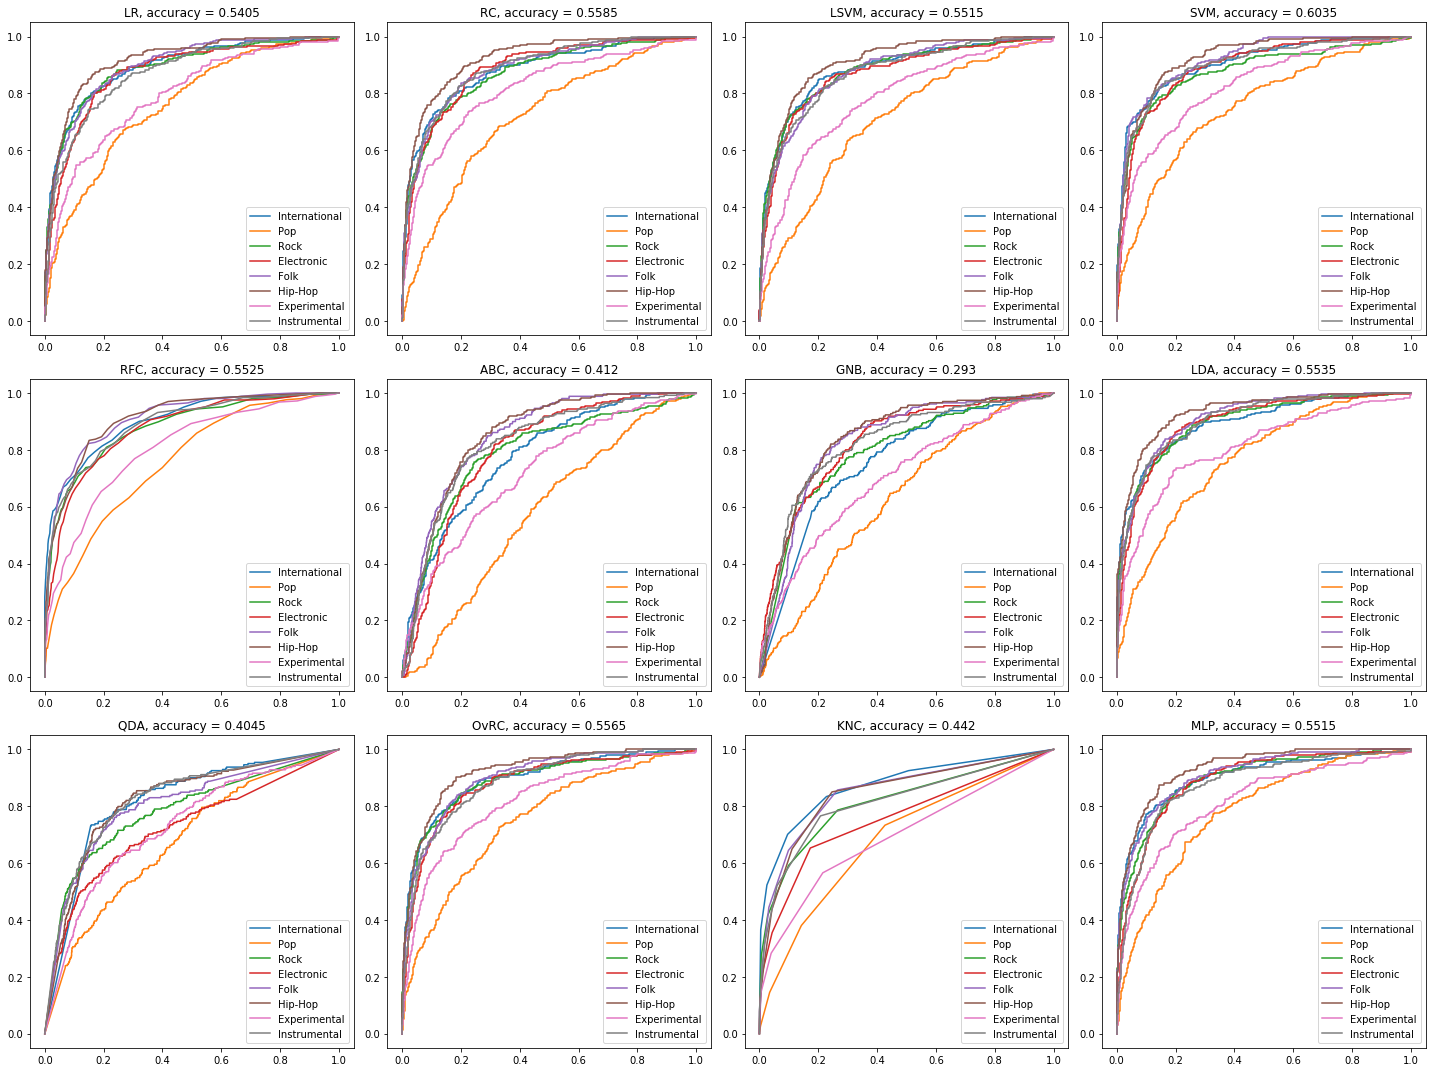

In [4]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for idx, (name, clf) in enumerate(classifiers.items()):
    for i, genre_id in enumerate(enc.classes_):
        axs[int(idx / 4)][idx % 4].plot(fpr[name][i], tpr[name][i], label=genres.loc[genre_id]["title"])
    
    axs[int(idx / 4)][idx % 4].set_title(f"{name}, accuracy = {score[name]}")
    axs[int(idx / 4)][idx % 4].legend()
fig.tight_layout()

# print(fpr["LR"][0][:10])
# print(fpr["GNB"][0][:10])